In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from datetime import datetime
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# parameters
random_seed = 42
lr = 0.001
batch_size = 32
n_epochs = 15
img_size = 32
n_classes = 10

In [4]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

train_set = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = datasets.MNIST(root='./data', train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

C:\Users\김동명\AppData\Local\Temp\ipykernel_14716\1098082342.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


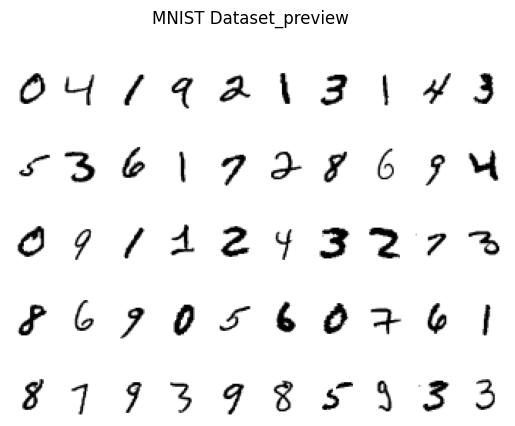

In [5]:
# 불러온 데이터 확인하기
row_img = 10
n_rows = 5

fig = plt.figure()
for index in range(1, row_img * n_rows+1):
    plt.subplot(n_rows, row_img, index)
    plt.axis('off')
    plt.imshow(train_set.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset_preview')
fig.show()

In [6]:
class LeNet5(nn.Module):
    def __init__(self,n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,1)
        logits = self.classifier(x)   # 어느 클래스 인가
        probs = F.softmax(logits, dim=1)  # 몇 % 인가
        return logits, probs

In [7]:
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for img, label in data_loader:
            img = img.to(device)
            label = label.to(device)
            
            _, y_prob = model(img)
            _, predicted = torch.max(y_prob, 1)
            
            total += label.size(0)
            correct += (predicted == label).sum()
            
    return correct.float() / total

In [8]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for img, label in train_loader:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        
        predicted, _ = model(img)   # 예측, 확률값
        loss = criterion(predicted, label)
        running_loss += loss.item() * img.size(0)
        
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [9]:
def validate(test_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        
        predicted, _ = model(img)
        loss = criterion(predicted,label)
        running_loss += loss.item() * img.size(0)
        
    epoch_loss = running_loss / len(test_loader.dataset)
    
    return model, epoch_loss

In [10]:
def training_loop(model, criterion, optimizer, train_loader, test_loader, epochs, device, print_every=1):

    train_losses = []
    valid_losses = []
    
    for epoch in range(0, epochs):
        
        #train
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        #validation
        with torch.no_grad():
            model, valid_loss = validate(test_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            
        if epoch % print_every == (print_every - 1 ):
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, test_loader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)}---'
                 f'Epoch: {epoch+1}\t'
                 f'Train loss: {train_loss:.4f}\t'
                 f'Valid loss: {valid_loss:.4f}\t'
                 f'Train acc: {100 * train_acc:.2f}\t'
                 f'Valid acc: {100 * valid_acc:.2f}\t')
            
    #plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [11]:
if __name__ == '__main__':
    torch.manual_seed(random_seed)
    
    model = LeNet5(n_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, test_loader, n_epochs, device)

15:32:47---Epoch: 1	Train loss: 0.2290	Valid loss: 0.1020	Train acc: 96.84	Valid acc: 96.81	
15:33:12---Epoch: 2	Train loss: 0.0762	Valid loss: 0.0619	Train acc: 98.39	Valid acc: 98.19	
15:33:37---Epoch: 3	Train loss: 0.0550	Valid loss: 0.0542	Train acc: 98.59	Valid acc: 98.45	
15:34:02---Epoch: 4	Train loss: 0.0438	Valid loss: 0.0486	Train acc: 99.07	Valid acc: 98.41	
15:34:27---Epoch: 5	Train loss: 0.0343	Valid loss: 0.0416	Train acc: 99.24	Valid acc: 98.74	
15:34:52---Epoch: 6	Train loss: 0.0299	Valid loss: 0.0422	Train acc: 99.40	Valid acc: 98.76	
15:35:17---Epoch: 7	Train loss: 0.0244	Valid loss: 0.0436	Train acc: 99.42	Valid acc: 98.52	
15:35:41---Epoch: 8	Train loss: 0.0220	Valid loss: 0.0464	Train acc: 99.43	Valid acc: 98.59	
15:36:07---Epoch: 9	Train loss: 0.0186	Valid loss: 0.0429	Train acc: 99.64	Valid acc: 98.66	
15:36:31---Epoch: 10	Train loss: 0.0162	Valid loss: 0.0442	Train acc: 99.65	Valid acc: 98.67	
15:36:57---Epoch: 11	Train loss: 0.0152	Valid loss: 0.0562	Train acc: